In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from einops import rearrange
import serial
import scipy
from IPython.display import HTML
import time

np.set_printoptions(precision=4, suppress=True)

In [230]:
com_port = "COM8"
com = serial.Serial(
    port=com_port,
    baudrate=115200,
    bytesize=8,
    timeout=2,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
)

In [3]:
def popcount(x):
    return bin(x).count("1")

def read_time_data(channels, points, sample_rate):
    com.write(b"\x01")
    # 1 byte for channel flag
    # 4 bytes for sample points
    # 4 bytes for sample rate
    com.write(channels.to_bytes(1, "little"))
    com.write(points.to_bytes(4, "little"))
    com.write(sample_rate.to_bytes(4, "little"))
    com.write(b"\xff\xff\xff")
    com.flush()
    head = com.read_until(b"\xff\xff\xff\xff")
    if head != b"\xff\xff\xff\xff":
        com.close()
        raise ValueError("Read timeout, invalid header")
    channel_count = popcount(channels)
    buf = com.read(channel_count * points * 2)
    arr = np.frombuffer(buf, dtype=np.int16)
    arr = rearrange(arr, "(n ch) -> ch n", ch=channel_count)
    return arr

def read_iq_test(points, sample_rate):
    com.write(b"\x03")
    # 4 bytes for sample points
    # 4 bytes for sample rate
    com.write(points.to_bytes(4, "little"))
    com.write(sample_rate.to_bytes(4, "little"))
    com.write(b"\xff\xff\xff")
    com.flush()
    head = com.read_until(b"\xff\xff\xff\xff")
    if head != b"\xff\xff\xff\xff":
        com.close()
        raise ValueError("Read timeout, invalid header")
    buf = com.read(3 * 8)
    arr = np.frombuffer(buf, dtype=np.float64)
    return arr


def plot_spectrum(data, points, sample_rate):
    data = data - np.mean(data)
    spec = np.fft.fft(data)
    amp = np.abs(spec)
    freq = np.fft.fftfreq(len(spec), 1 / sample_rate)
    plt.plot(freq[:points//2], amp[:points//2])
    print(f"Peak frequency: {np.abs(freq[np.argmax(amp)])}")

def set_frequency(freq):
    com.write(b"\x02")
    com.write(freq.to_bytes(4, "little"))
    com.write(b"\xff\xff\xff")
    com.flush()

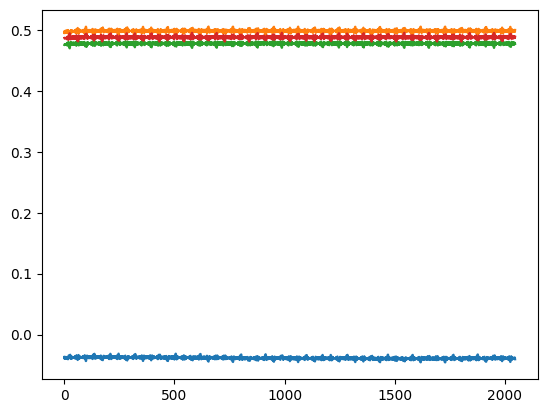

In [202]:
set_frequency(100000000)
sample_rate = 200000
points = 2048
data = read_time_data(0b1111, points, sample_rate)
data = data * 2.5 / 32768
for i in range(4):
    plt.plot(data[i])
plt.show()

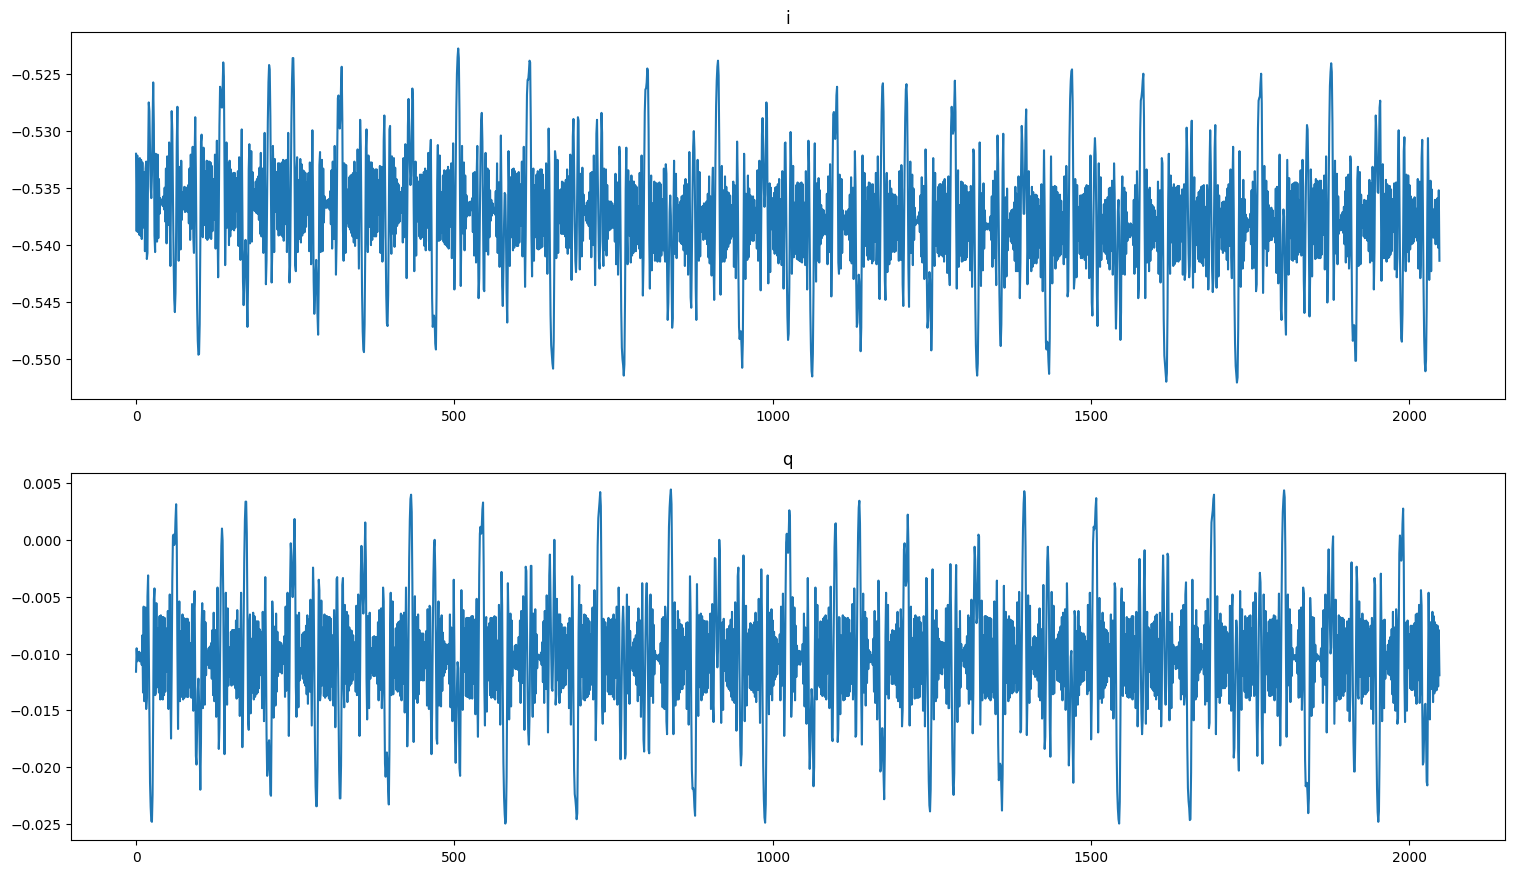

In [203]:
I = data[0] - data[1]
Q = data[2] - data[3]
# i = i - np.mean(i)
# q = q - np.mean(q)
fig, axs = plt.subplots(2)
fig.set_size_inches(18.5, 10.5)
axs[0].plot(I)
axs[0].title.set_text("i")
axs[1].plot(Q)
axs[1].title.set_text("q")
plt.show()

Peak frequency: 3320.3124999999995
Peak frequency: 3320.3124999999995


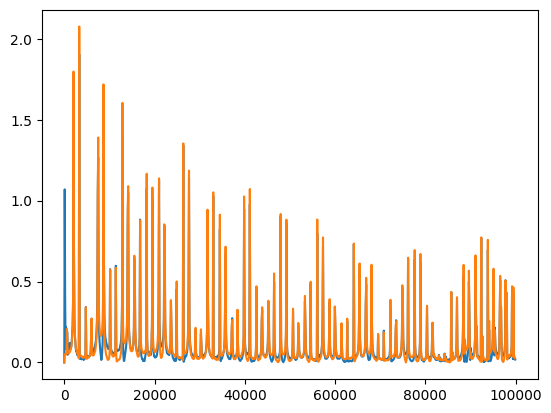

In [204]:
plot_spectrum(I, points, sample_rate)
plot_spectrum(Q, points, sample_rate)
plt.show()

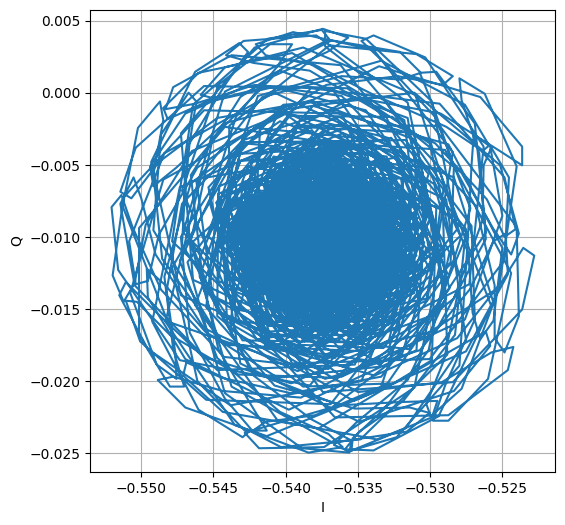

In [205]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel("I")
ax.set_ylabel("Q")
line, = ax.plot(I, Q)
ax.axis("equal")
ax.grid()
plt.show()

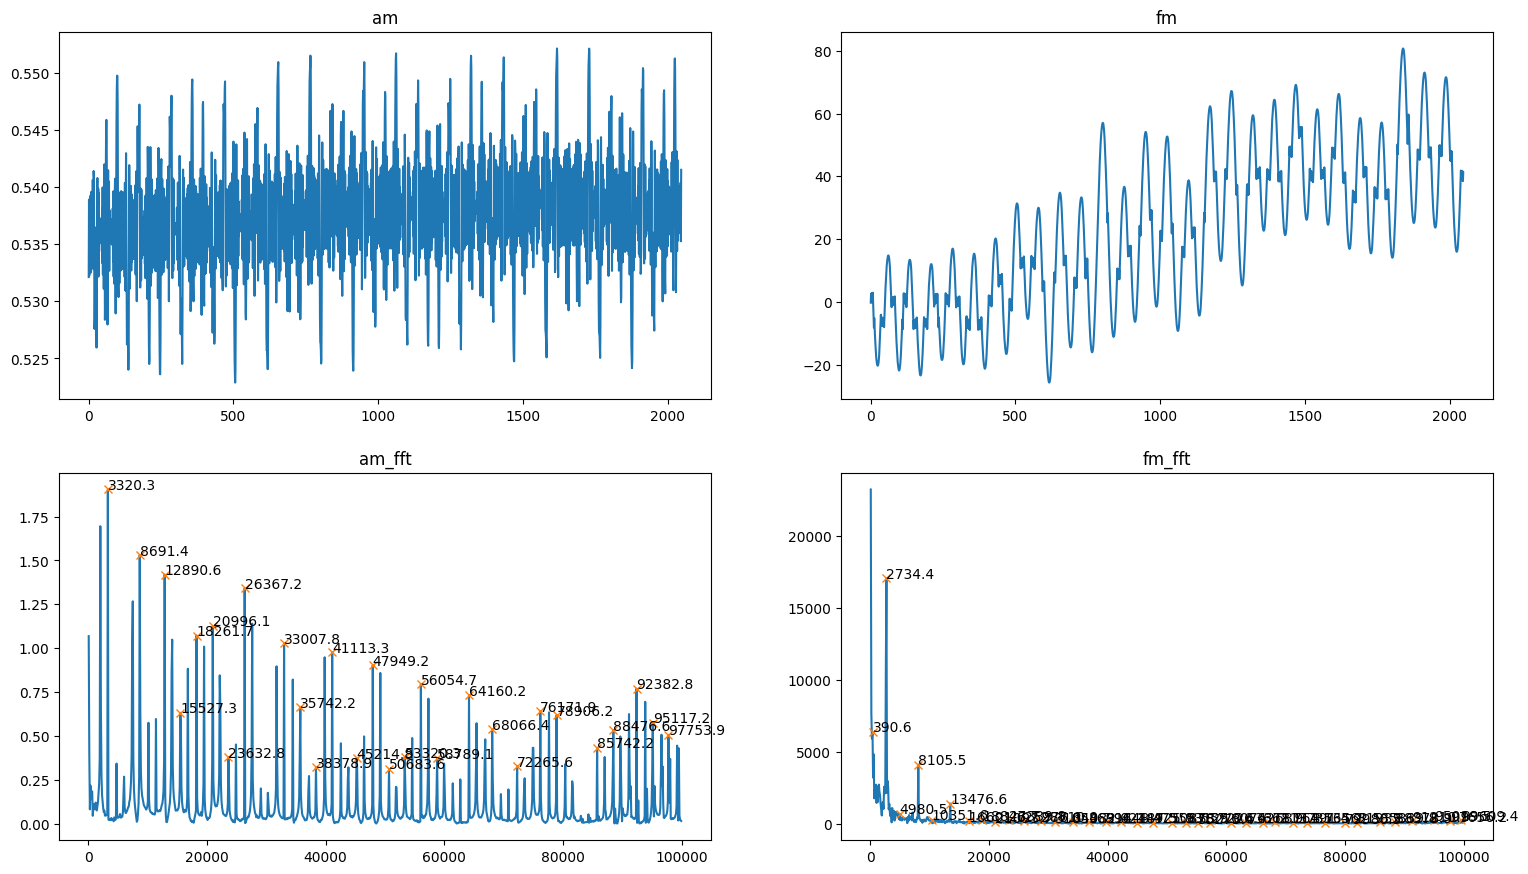

In [206]:
am = np.sqrt(I**2 + Q**2)
fm = np.arctan2(Q - np.mean(Q), I - np.mean(I))
fm = np.unwrap(fm)
am_fft = np.abs(np.fft.fft(am))[1:points//2]
fm_fft = np.abs(np.fft.fft(fm))[1:points//2]
freq = np.fft.fftfreq(points, 1 / sample_rate)[1:points//2]
am_peaks, _ = scipy.signal.find_peaks(am_fft, height=0.3, distance=20)
fm_peaks, _ = scipy.signal.find_peaks(fm_fft, height=0.3, distance=20)
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)
axs[0, 0].plot(am)
axs[0, 0].title.set_text("am")
axs[0, 1].plot(fm)
axs[0, 1].title.set_text("fm")
axs[1, 0].plot(freq, am_fft)
axs[1, 0].plot(freq[am_peaks], am_fft[am_peaks], "x")
for i in range(len(am_peaks)):
    axs[1, 0].annotate(f"{freq[am_peaks[i]]:.1f}", (freq[am_peaks[i]], am_fft[am_peaks[i]]))
axs[1, 0].title.set_text("am_fft")
axs[1, 1].plot(freq, fm_fft)
axs[1, 1].plot(freq[fm_peaks], fm_fft[fm_peaks], "x")
for i in range(len(fm_peaks)):
    axs[1, 1].annotate(f"{freq[fm_peaks[i]]:.1f}", (freq[fm_peaks[i]], fm_fft[fm_peaks[i]]))
axs[1, 1].title.set_text("fm_fft")
plt.show()

In [218]:
read_iq_test(points, sample_rate)

array([  0.7599, 195.3125,  97.6562])

In [61]:
import pyvisa
rm = pyvisa.ResourceManager()
devices = rm.list_resources()
if (len(devices) == 1):
    device = rm.open_resource(devices[0])
else:
    print(devices)
    device_addr = input("Enter device address: ")
    device = rm.open_resource(device_addr)

('USB0::0xF4EC::0x1102::SDG2XBA4150426::INSTR', 'ASRL8::INSTR')


In [219]:
from tqdm.notebook import trange
fm_freq = np.arange(300, 3000, 300)
fm_dev = np.arange(5000, 100000, 15000)
fm_freq, fm_dev = np.meshgrid(fm_freq, fm_dev)
result_detection = np.zeros_like(fm_freq)
result_freq = np.zeros_like(fm_freq)
for i in trange(fm_freq.shape[0]):
    for j in range(fm_freq.shape[1]):
        device.write(f"C2:MDWV FM,FRQ,{fm_freq[i, j]}")
        device.write(f"C2:MDWV FM,DEVI,{fm_dev[i, j]}")
        time.sleep(1)
        
        cur = read_iq_test(points, sample_rate)
        result_detection[i, j] = cur[0]
        result_freq[i, j] = cur[2]

  0%|          | 0/7 [00:00<?, ?it/s]

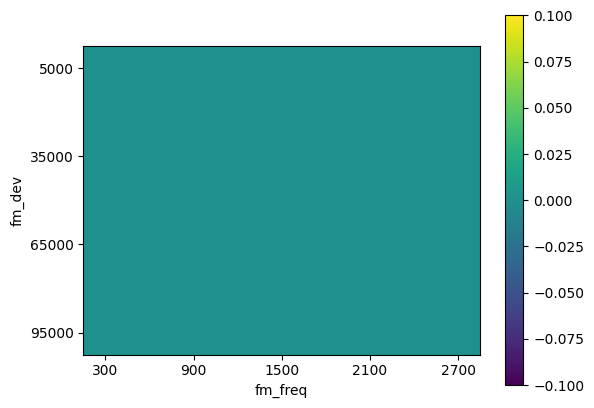

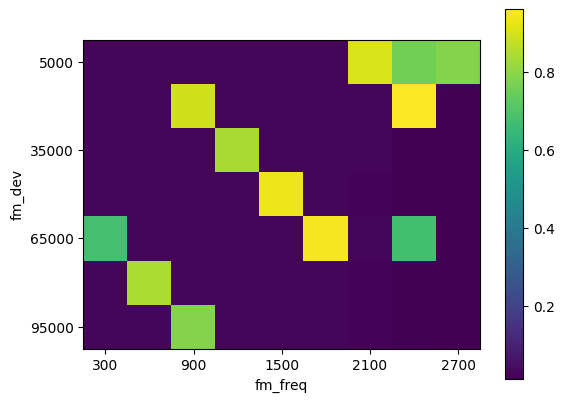

In [220]:

freq_err = np.abs(result_freq - fm_freq) / fm_freq
plt.imshow(np.abs(result_detection))
plt.xlabel("fm_freq")
plt.xticks(np.arange(0, fm_freq.shape[1], 2), fm_freq[0, ::2])
plt.ylabel("fm_dev")
plt.yticks(np.arange(0, fm_dev.shape[0], 2), fm_dev[::2, 0])
plt.colorbar()
plt.show()

plt.imshow(freq_err)
plt.xlabel("fm_freq")
plt.xticks(np.arange(0, fm_freq.shape[1], 2), fm_freq[0, ::2])
plt.ylabel("fm_dev")
plt.yticks(np.arange(0, fm_dev.shape[0], 2), fm_dev[::2, 0])
plt.colorbar()
plt.show()

In [101]:
freq_err

array([[0.5133, 0.7567, 0.8378, 0.8783, 0.9027, 0.8378, 0.9305, 0.9392,
        0.9459],
       [0.0267, 0.025 , 0.8378, 0.0242, 0.9027, 0.9189, 0.861 , 0.8783,
        0.6204],
       [0.0267, 0.025 , 0.8378, 0.8783, 0.7073, 0.0239, 0.861 , 0.9392,
        0.7289],
       [7.3   , 0.025 , 0.8378, 0.7567, 0.7073, 0.9189, 0.5819, 0.0375,
        0.8919],
       [0.5133, 0.9517, 0.8378, 0.0242, 0.3167, 0.5933, 0.3724, 0.9392,
        0.8919],
       [0.5133, 0.025 , 0.0244, 0.7567, 0.7073, 0.9189, 0.0238, 0.8783,
        0.9459],
       [0.0267, 0.7567, 0.35  , 0.9525, 0.7073, 0.3494, 0.3724, 0.6342,
        0.7289]])

In [32]:
from tqdm.notebook import trange
am_freq = np.concatenate((np.arange(200, 1000, 200), np.arange(1000, 10001, 2000)))
am_depth = np.arange(40, 101, 20)
am_freq, am_depth = np.meshgrid(am_freq, am_depth)
result_detection = np.zeros_like(am_freq)
result_freq = np.zeros_like(am_freq)
for i in trange(am_freq.shape[0]):
    for j in range(am_freq.shape[1]):
        device.write(f"C2:MDWV AM,FRQ,{am_freq[i, j]}")
        device.write(f"C2:MDWV AM,DEPTH,{am_depth[i, j]}")
        time.sleep(1)
        
        cur = read_iq_test(points, sample_rate)
        result_detection[i, j] = cur[0]
        result_freq[i, j] = cur[1]

  0%|          | 0/4 [00:00<?, ?it/s]

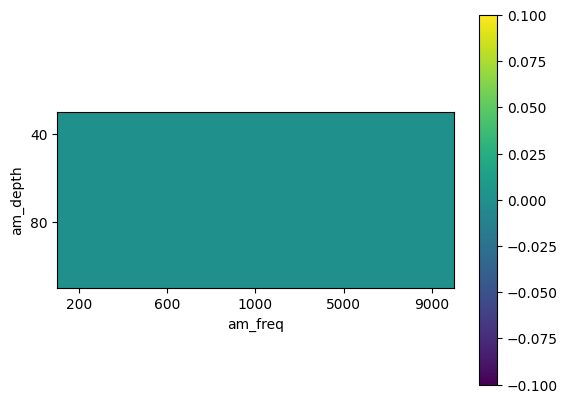

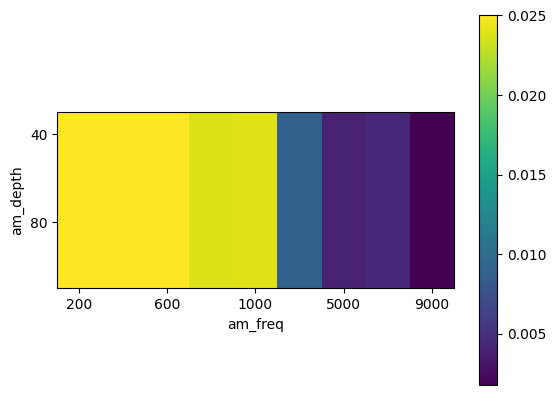

In [33]:
freq_err = np.abs(result_freq - am_freq) / am_freq
plt.imshow(np.abs(result_detection))
plt.xlabel("am_freq")
plt.xticks(np.arange(0, am_freq.shape[1], 2), am_freq[0, ::2])
plt.ylabel("am_depth")
plt.yticks(np.arange(0, am_depth.shape[0], 2), am_depth[::2, 0])
plt.colorbar()
plt.show()

plt.imshow(freq_err)
plt.xlabel("am_freq")
plt.xticks(np.arange(0, am_freq.shape[1], 2), am_freq[0, ::2])
plt.ylabel("am_depth")
plt.yticks(np.arange(0, am_depth.shape[0], 2), am_depth[::2, 0])
plt.colorbar()
plt.show()

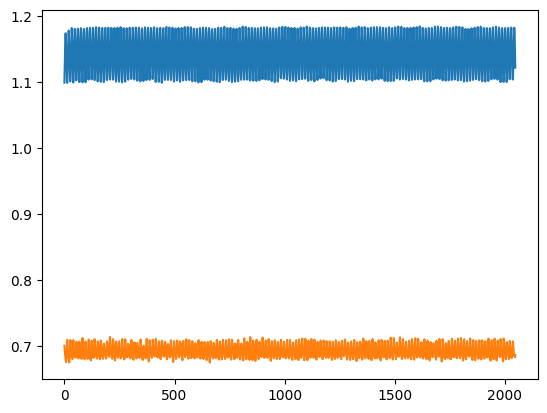

In [277]:
set_frequency(40000000)
data = read_time_data(0b0011, points, sample_rate) * 2.5 / 32767
plt.plot(data[0])
plt.plot(data[1])
plt.show()

Peak frequency: 14453.124999999998
Peak frequency: 14453.124999999998


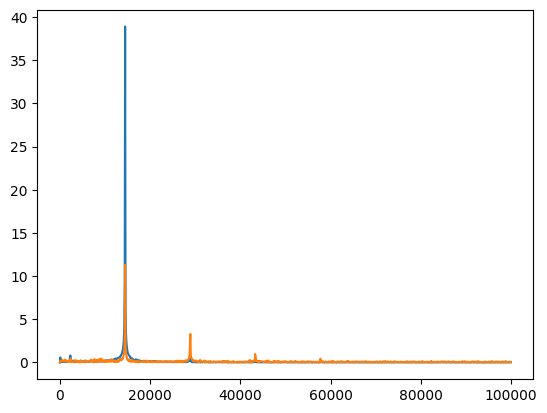

In [278]:
plot_spectrum(data[0], points, sample_rate)
plot_spectrum(data[1], points, sample_rate)
plt.show()

In [279]:
def signal_to_noise_ratio(data):
    return np.mean(data) / np.std(data)

print(signal_to_noise_ratio(data[0]))
print(signal_to_noise_ratio(data[1]))

39.9864601362853
75.50462852514144
